In [1]:
import os
import pydicom

def load_dicom_folder(folder_path):
    dicom_files = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            try:
                ds = pydicom.dcmread(filepath, force=True)
                dicom_files.append(ds)
            except Exception as e:
                print(f"Не удалось прочитать {filepath}: {e}")
    return dicom_files

# Задай путь к папке с DICOM-файлами (используй raw-строку)
folder_path = r"E:\dicom dataset\1Р\DICOM\11101015\12160000"
dicom_data = load_dicom_folder(folder_path)
print("Количество успешно загруженных DICOM-файлов:", len(dicom_data))

# Если файл(ы) успешно загружены, извлекаем информацию о пациенте из первого файла
if dicom_data:
    ds = dicom_data[0]  # Обычно все файлы одного исследования содержат одинаковую информацию о пациенте
    patient_name = ds.get("PatientName", "Не указано")
    patient_id = ds.get("PatientID", "Не указан")
    patient_sex = ds.get("PatientSex", "Не указан")
    patient_birth_date = ds.get("PatientBirthDate", "Не указано")
    
    print("Имя пациента:", patient_name)
    print("ID пациента:", patient_id)
    print("Пол:", patient_sex)
    print("Дата рождения:", patient_birth_date)
else:
    print("Нет загруженных файлов.")


Количество успешно загруженных DICOM-файлов: 300
Имя пациента: 01-P
ID пациента: 111111
Пол: M
Дата рождения: 19900101


Найдено DICOM файлов (без расширения): 215
Размер вокселя (PixelSpacing и SliceThickness): [0.52734375, 0.52734375, 4.5]
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795594 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795583 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795572 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795561 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795550 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795539 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795528 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795517 (нет пиксельных данных)
Уникальные размеры изображений: {(512, 512), (320, 304), (448, 354), (320, 260)}
Изображение E:\dicom dataset\1П\DICOM\13050311\5915000

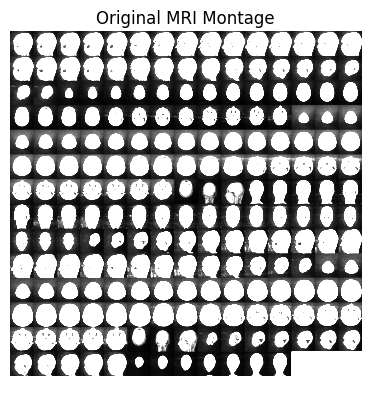

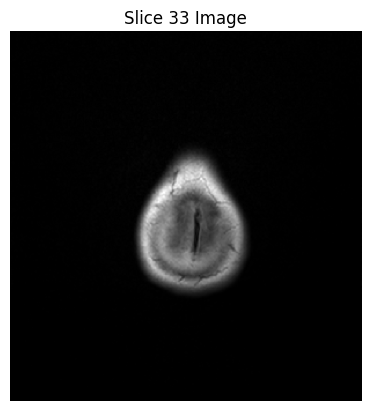

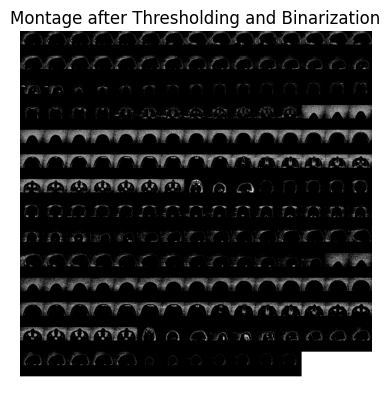

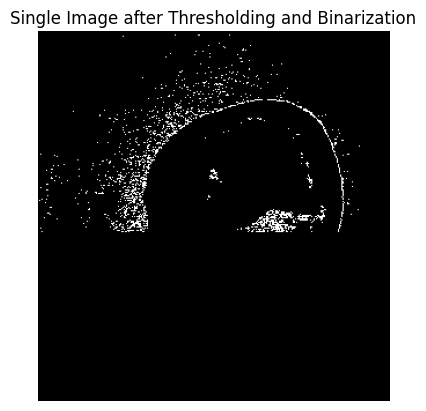

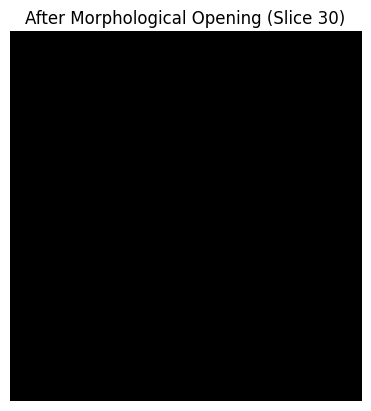

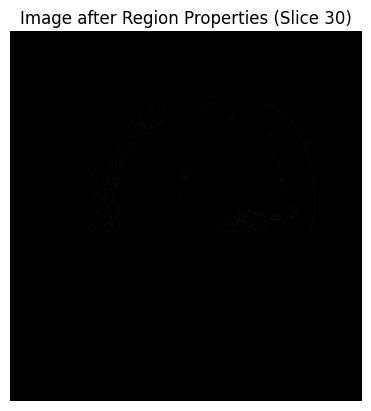

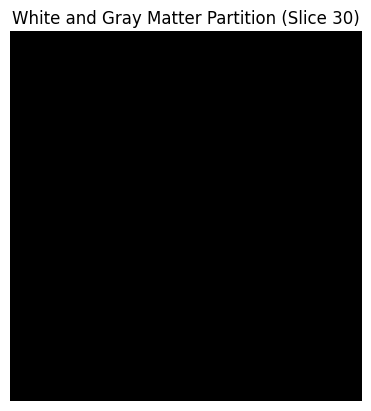

ValueError: Surface level must be within volume data range.

In [2]:
#!/usr/bin/env python3
"""
Дипломный проект – базовая обработка МРТ-изображений головного мозга, сегментация, 3D-реконструкция и визуализация.
Для работы требуется установка:
    pip install numpy matplotlib pydicom scikit-image scipy
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.ndimage import binary_opening
from skimage.transform import resize
from skimage.measure import label, regionprops, marching_cubes
from skimage.filters import threshold_otsu
from skimage.util import montage as montage_util
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#############################################
# 1. Чтение DICOM-файлов (файлы без расширения)
#############################################
# Используем сырую строку для указания пути, чтобы избежать warning'ов.
folder_path = os.path.join(os.getcwd(), r"E:\dicom dataset\1П\DICOM\13050311\59150000")

# Получаем список всех файлов в папке и отбираем файлы без расширения
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files = [os.path.join(folder_path, f) for f in all_files if os.path.splitext(f)[1] == '']

if not dicom_files:
    raise Exception("Файлы без расширения не найдены в папке.")

print("Найдено DICOM файлов (без расширения):", len(dicom_files))

# Считываем информацию из первого файла для определения размеров вокселя
ds0 = pydicom.dcmread(dicom_files[0])
pixel_spacing = ds0.PixelSpacing  # Например, [0.52734375, 0.52734375]
slice_thickness = ds0.SliceThickness  # Например, 4.5
voxel_size = [float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)]
print("Размер вокселя (PixelSpacing и SliceThickness):", voxel_size)

#############################################
# 2. Формирование списка 2D-изображений
#############################################
data_images_list = []
for file in reversed(dicom_files):
    try:
        ds = pydicom.dcmread(file)
        # Проверяем наличие пиксельных данных
        if 'PixelData' in ds:
            image = ds.pixel_array.astype(np.uint16)
            data_images_list.append(image)
        else:
            print(f"Пропускаем файл {file} (нет пиксельных данных)")
    except Exception as e:
        print(f"Ошибка при чтении файла {file}: {e}")

#############################################
# 3. Приведение изображений к одной форме
#############################################

# Выводим уникальные размеры изображений
unique_shapes = {img.shape for img in data_images_list}
print("Уникальные размеры изображений:", unique_shapes)

# Если размеры различаются, приводим все изображения к форме первого изображения
target_shape = data_images_list[0].shape
aligned_images = []
for idx, img in enumerate(data_images_list):
    if img.shape != target_shape:
        print(f"Изображение {dicom_files[idx]} с формой {img.shape} изменено до {target_shape}")
        img_resized = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint16)
        aligned_images.append(img_resized)
    else:
        aligned_images.append(img)

# Формируем 3D-массив (rows x cols x num_slices)
data_images = np.stack(aligned_images, axis=2)
print("Сформирован 3D-массив с формой:", data_images.shape)

#############################################
# 4. Просмотр исходной МРТ – монтаж и отдельный срез
#############################################

# Создаем монтаж всех срезов (транспонируем массив так, чтобы ось срезов была первой)
montage_img = montage_util(data_images.transpose(2, 0, 1), grid_shape=None)
plt.figure()
plt.imshow(montage_img, cmap='gray', vmin=0, vmax=100)
plt.title("Original MRI Montage")
plt.axis('off')
plt.show()

# Просмотр выбранного среза (например, 33–й; индекс 32, так как нумерация начинается с 0)
slice_index = 32
selected_image = data_images[:, :, slice_index]
max_value = float(selected_image.max())
plt.figure()
plt.imshow(selected_image, cmap='gray', vmin=0, vmax=max_value)
plt.title("Slice 33 Image")
plt.axis('off')
plt.show()

#############################################
# 5. Базовая сегментация: пороговая обработка и морфологическая очистка
#############################################

SegmentedBrainMRI = data_images.copy()

# Устанавливаем пороговые границы
Threshold_lowerBound = 40
Threshold_upperBound = 100

# Обнуляем пиксели вне заданного диапазона
SegmentedBrainMRI[SegmentedBrainMRI >= Threshold_upperBound] = 0
SegmentedBrainMRI[SegmentedBrainMRI <= Threshold_lowerBound] = 0

# Обнуляем нижнюю часть изображения (начиная с 175-й строки; индекс 174)
SegmentedBrainMRI[174:, :, :] = 0

# Создаем бинарное изображение (True, если значение больше 0)
black_white = SegmentedBrainMRI > 0

# Монтаж после пороговой обработки и бинаризации
montage_bw = montage_util(black_white.transpose(2, 0, 1), grid_shape=None)
plt.figure()
plt.imshow(montage_bw, cmap='gray')
plt.title("Montage after Thresholding and Binarization")
plt.axis('off')
plt.show()

# Отображаем отдельный срез (например, 30–й; индекс 29)
plt.figure()
plt.imshow(black_white[:, :, 29], cmap='gray')
plt.title("Single Image after Thresholding and Binarization")
plt.axis('off')
plt.show()

# Применяем морфологическое открытие с структурирующим элементом 7x7x3
structuring_element = np.ones((7, 7, 3), dtype=bool)
black_white = binary_opening(black_white, structure=structuring_element)
plt.figure()
plt.imshow(black_white[:, :, 29], cmap='gray')
plt.title("After Morphological Opening (Slice 30)")
plt.axis('off')
plt.show()

#############################################
# 6. Выделение самой большой связной области (мозга)
#############################################

label_matrix = label(black_white, connectivity=2)
props = regionprops(label_matrix)
if props:
    areas = [prop.area for prop in props]
    max_idx = np.argmax(areas)
    biggest_label = props[max_idx].label
else:
    biggest_label = 0

# Оставляем в сегментированном изображении только самый крупный компонент
segmented_brain = SegmentedBrainMRI.copy()
segmented_brain[label_matrix != biggest_label] = 0
plt.figure()
plt.imshow(segmented_brain[:, :, 29], cmap='gray', vmin=0, vmax=max_value)
plt.title("Image after Region Properties (Slice 30)")
plt.axis('off')
plt.show()

#############################################
# 7. Разделение белого и серого вещества (методом Оцу)
#############################################

slice_for_thresh = segmented_brain[:, :, 29]
if np.any(slice_for_thresh):
    level = threshold_otsu(slice_for_thresh.astype(np.uint16))
else:
    level = 0

# Создаем изображение разделения (0 – фон, 2 – серое вещество, 3 – белое вещество)
mriPartition = np.zeros(segmented_brain.shape, dtype=np.uint8)
mriPartition[(segmented_brain > 0) & (segmented_brain < level)] = 2
mriPartition[segmented_brain >= level] = 3

plt.figure()
plt.imshow(mriPartition[:, :, 29], cmap='gray', vmin=0, vmax=max_value)
plt.title("White and Gray Matter Partition (Slice 30)")
plt.axis('off')
plt.show()

#############################################
# 8. 3D-реконструкция и визуализация
#############################################
plt.close('all')  # Закрываем предыдущие окна графиков

# Downsample (уменьшение размера в два раза) для 3D-визуализации
Ds = resize(mriPartition,
            (mriPartition.shape[0] // 2, mriPartition.shape[1] // 2, mriPartition.shape[2] // 2),
            order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

# "Переворот" осей: flip по первой и второй оси, затем перестановка осей (аналог permute([3,2,1]) в MATLAB)
Ds = np.flip(Ds, axis=0)
Ds = np.flip(Ds, axis=1)
Ds = np.transpose(Ds, (2, 1, 0))  # Итоговый объем имеет форму (slices, cols, rows)

# Корректное масштабирование вокселей, умножаем компоненты на [4, 1, 4]
voxel_size2 = np.array([voxel_size[0] * 4, voxel_size[1] * 1, voxel_size[2] * 4])

# Извлечение изоповерхностей (marching cubes) для "белого" (iso-level 2.5) и "серого" (iso-level 1.5) вещества
white_verts, white_faces, _, _ = marching_cubes(Ds, level=2.5)
gray_verts, gray_faces, _, _ = marching_cubes(Ds, level=1.5)

# Корректное масштабирование вершин
scale_factors = [voxel_size2[2], voxel_size2[1], voxel_size2[0]]  # порядок осей: [x, y, z]
white_verts_scaled = white_verts * scale_factors
gray_verts_scaled = gray_verts * scale_factors

# Построение 3D-модели с помощью Poly3DCollection в Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
white_mesh = Poly3DCollection(white_verts_scaled[white_faces], facecolor="red", edgecolor="none")
gray_mesh = Poly3DCollection(gray_verts_scaled[gray_faces], facecolor="yellow", edgecolor="none", alpha=0.5)
ax.add_collection3d(white_mesh)
ax.add_collection3d(gray_mesh)

# Определение пределов по осям на основе всех вершин
all_vertices = np.concatenate([white_verts_scaled, gray_verts_scaled])
ax.set_xlim(np.min(all_vertices[:, 0]), np.max(all_vertices[:, 0]))
ax.set_ylim(np.min(all_vertices[:, 1]), np.max(all_vertices[:, 1]))
ax.set_zlim(np.min(all_vertices[:, 2]), np.max(all_vertices[:, 2]))

# Установка угла обзора
ax.view_init(elev=45, azim=45)
plt.axis('off')
plt.title("3D Rendering of Brain")
plt.show()


Найдено DICOM файлов (без расширения): 215
Размер вокселя (PixelSpacing и SliceThickness): [0.52734375, 0.52734375, 4.5]
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795594 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795583 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795572 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795561 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795550 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795539 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795528 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795517 (нет пиксельных данных)
Уникальные размеры изображений: {(512, 512), (320, 304), (448, 354), (320, 260)}
Изображение E:\dicom dataset\1П\DICOM\13050311\5915000

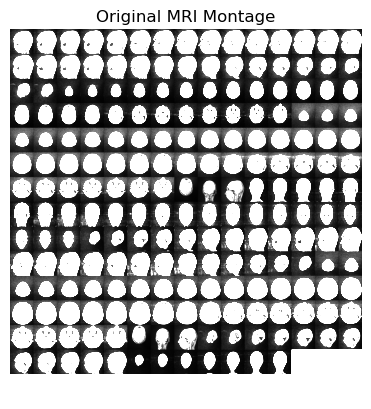

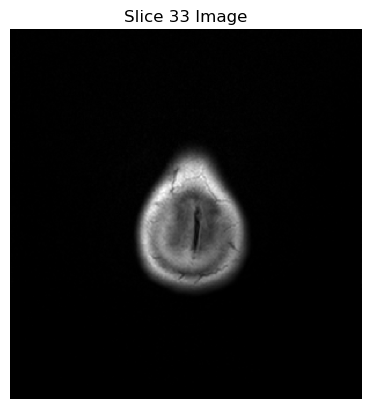

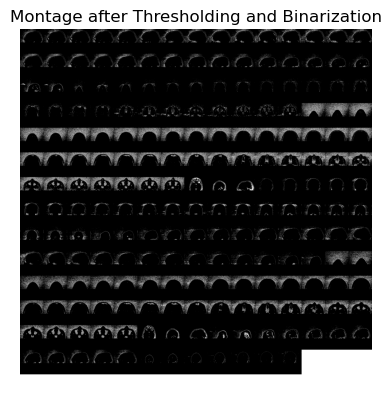

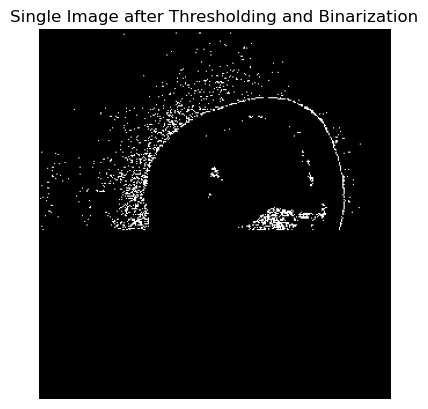

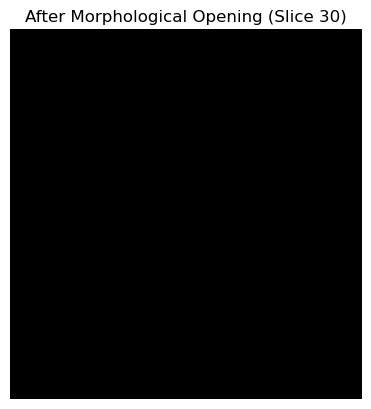

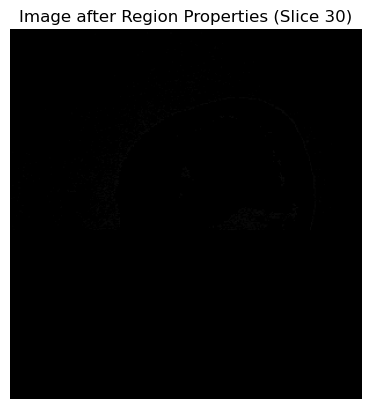

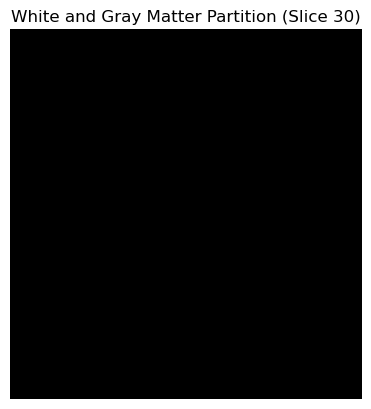

Диапазон значений в Ds: 3 3
Уникальные значения в Ds: [3]
Объем однородный. Извлечение изоповерхности невозможно, поскольку все элементы равны: 3


SystemExit: Извлечение изоповерхности отменено из-за однородного объема.

D:\ANACONDA\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
#!/usr/bin/env python3
"""
Дипломный проект – базовая обработка МРТ-изображений головного мозга, сегментация, 3D-реконструкция и визуализация.
Для работы требуется установка:
    pip install numpy matplotlib pydicom scikit-image scipy
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.ndimage import binary_opening
from skimage.transform import resize
from skimage.measure import label, regionprops, marching_cubes
from skimage.filters import threshold_otsu
from skimage.util import montage as montage_util
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#############################################
# 1. Чтение DICOM-файлов (файлы без расширения)
#############################################
# Используем сырую строку для указания пути, чтобы избежать предупреждений по escape-последовательностям.
folder_path = os.path.join(os.getcwd(), r"E:\dicom dataset\1П\DICOM\13050311\59150000")

# Получаем список всех файлов в папке и отбираем файлы без расширения
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files = [os.path.join(folder_path, f) for f in all_files if os.path.splitext(f)[1] == '']

if not dicom_files:
    raise Exception("Файлы без расширения не найдены в папке.")

print("Найдено DICOM файлов (без расширения):", len(dicom_files))

# Считываем информацию из первого файла для определения размеров вокселя
ds0 = pydicom.dcmread(dicom_files[0])
pixel_spacing = ds0.PixelSpacing  # например, [0.52734375, 0.52734375]
slice_thickness = ds0.SliceThickness  # например, 4.5
voxel_size = [float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)]
print("Размер вокселя (PixelSpacing и SliceThickness):", voxel_size)

#############################################
# 2. Формирование списка 2D-изображений
#############################################
data_images_list = []
for file in reversed(dicom_files):
    try:
        ds = pydicom.dcmread(file)
        # Проверяем наличие пиксельных данных
        if 'PixelData' in ds:
            image = ds.pixel_array.astype(np.uint16)
            data_images_list.append(image)
        else:
            print(f"Пропускаем файл {file} (нет пиксельных данных)")
    except Exception as e:
        print(f"Ошибка при чтении файла {file}: {e}")

#############################################
# 3. Приведение изображений к одной форме
#############################################
# Выводим уникальные размеры изображений
unique_shapes = {img.shape for img in data_images_list}
print("Уникальные размеры изображений:", unique_shapes)

# Если размеры различаются, приводим все изображения к форме первого изображения
target_shape = data_images_list[0].shape
aligned_images = []
for idx, img in enumerate(data_images_list):
    if img.shape != target_shape:
        print(f"Изображение {dicom_files[idx]} с формой {img.shape} изменено до {target_shape}")
        img_resized = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint16)
        aligned_images.append(img_resized)
    else:
        aligned_images.append(img)

# Формируем 3D-массив (rows x cols x num_slices)
data_images = np.stack(aligned_images, axis=2)
print("Сформирован 3D-массив с формой:", data_images.shape)

#############################################
# 4. Просмотр исходной МРТ – монтаж и отдельный срез
#############################################
# Создаем монтаж всех срезов (транспонируем массив так, чтобы ось срезов была первой)
montage_img = montage_util(data_images.transpose(2, 0, 1), grid_shape=None)
plt.figure()
plt.imshow(montage_img, cmap='gray', vmin=0, vmax=100)
plt.title("Original MRI Montage")
plt.axis('off')
plt.show()

# Просмотр выбранного среза (например, 33-й; индекс 32)
slice_index = 32
selected_image = data_images[:, :, slice_index]
max_value = float(selected_image.max())
plt.figure()
plt.imshow(selected_image, cmap='gray', vmin=0, vmax=max_value)
plt.title("Slice 33 Image")
plt.axis('off')
plt.show()

#############################################
# 5. Базовая сегментация: пороговая обработка и морфологическая очистка
#############################################
SegmentedBrainMRI = data_images.copy()

# Устанавливаем пороговые границы
Threshold_lowerBound = 40
Threshold_upperBound = 100

# Обнуляем пиксели вне заданного диапазона
SegmentedBrainMRI[SegmentedBrainMRI >= Threshold_upperBound] = 0
SegmentedBrainMRI[SegmentedBrainMRI <= Threshold_lowerBound] = 0

# Обнуляем нижнюю часть изображения (начиная с 175-й строки; индекс 174)
SegmentedBrainMRI[174:, :, :] = 0

# Создаем бинарное изображение (True, если значение больше 0)
black_white = SegmentedBrainMRI > 0

# Монтаж после пороговой обработки и бинаризации
montage_bw = montage_util(black_white.transpose(2, 0, 1), grid_shape=None)
plt.figure()
plt.imshow(montage_bw, cmap='gray')
plt.title("Montage after Thresholding and Binarization")
plt.axis('off')
plt.show()

# Отображаем отдельный срез (например, 30-й; индекс 29)
plt.figure()
plt.imshow(black_white[:, :, 29], cmap='gray')
plt.title("Single Image after Thresholding and Binarization")
plt.axis('off')
plt.show()

# Применяем морфологическое открытие с структурирующим элементом 7x7x3
structuring_element = np.ones((7, 7, 3), dtype=bool)
black_white = binary_opening(black_white, structure=structuring_element)
plt.figure()
plt.imshow(black_white[:, :, 29], cmap='gray')
plt.title("After Morphological Opening (Slice 30)")
plt.axis('off')
plt.show()

#############################################
# 6. Выделение самой большой связной области (мозга)
#############################################
label_matrix = label(black_white, connectivity=2)
props = regionprops(label_matrix)
if props:
    areas = [prop.area for prop in props]
    max_idx = np.argmax(areas)
    biggest_label = props[max_idx].label
else:
    biggest_label = 0

# Оставляем в сегментированном изображении только самый крупный компонент
segmented_brain = SegmentedBrainMRI.copy()
segmented_brain[label_matrix != biggest_label] = 0
plt.figure()
plt.imshow(segmented_brain[:, :, 29], cmap='gray', vmin=0, vmax=max_value)
plt.title("Image after Region Properties (Slice 30)")
plt.axis('off')
plt.show()

#############################################
# 7. Разделение белого и серого вещества (методом Оцу)
#############################################
slice_for_thresh = segmented_brain[:, :, 29]
if np.any(slice_for_thresh):
    level = threshold_otsu(slice_for_thresh.astype(np.uint16))
else:
    level = 0

# Формируем изображение разделения (0 – фон, 2 – серое вещество, 3 – белое вещество)
mriPartition = np.zeros(segmented_brain.shape, dtype=np.uint8)
mriPartition[(segmented_brain > 0) & (segmented_brain < level)] = 2
mriPartition[segmented_brain >= level] = 3

plt.figure()
plt.imshow(mriPartition[:, :, 29], cmap='gray', vmin=0, vmax=max_value)
plt.title("White and Gray Matter Partition (Slice 30)")
plt.axis('off')
plt.show()

#############################################
# 8. 3D-реконструкция и визуализация
#############################################
plt.close('all')  # Закрываем предыдущие окна графиков

# Downsample (уменьшение размера в два раза) для 3D-визуализации
Ds = resize(mriPartition,
            (mriPartition.shape[0] // 2, mriPartition.shape[1] // 2, mriPartition.shape[2] // 2),
            order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

# "Переворот" осей: flip по первой и второй оси, затем перестановка осей (аналог permute([3,2,1]) в MATLAB)
Ds = np.flip(Ds, axis=0)
Ds = np.flip(Ds, axis=1)
Ds = np.transpose(Ds, (2, 1, 0))  # Итоговый объем имеет форму (slices, cols, rows)

# Получаем диапазон значений в объеме Ds
ds_min = Ds.min()
ds_max = Ds.max()
print("Диапазон значений в Ds:", ds_min, ds_max)
print("Уникальные значения в Ds:", np.unique(Ds))

if ds_min == ds_max:
    print("Объем однородный. Извлечение изоповерхности невозможно, поскольку все элементы равны:", ds_min)
    sys.exit("Извлечение изоповерхности отменено из-за однородного объема.")
else:
    # Задаем уровни для marching_cubes (изначально 2.5 для белого и 1.5 для серого)
    white_level = 2.5
    gray_level = 1.5
    if not (ds_min < white_level < ds_max):
        white_level = ds_min + 0.5 * (ds_max - ds_min)
        print("Изменен уровень для белого вещества:", white_level)
    if not (ds_min < gray_level < ds_max):
        gray_level = ds_min + 0.25 * (ds_max - ds_min)
        print("Изменен уровень для серого вещества:", gray_level)
    
    print("Используемый уровень для белого вещества:", white_level)
    print("Используемый уровень для серого вещества:", gray_level)
    
    # Извлечение изоповерхностей с использованием marching_cubes
    white_verts, white_faces, _, _ = marching_cubes(Ds, level=white_level)
    gray_verts, gray_faces, _, _ = marching_cubes(Ds, level=gray_level)

# Корректное масштабирование вершин.
# Определяем коэффициенты масштабирования. Порядок осей: [x, y, z].
voxel_size2 = np.array([voxel_size[0] * 4, voxel_size[1] * 1, voxel_size[2] * 4])
scale_factors = [voxel_size2[2], voxel_size2[1], voxel_size2[0]]
white_verts_scaled = white_verts * scale_factors
gray_verts_scaled = gray_verts * scale_factors

# Построение 3D-модели с использованием Poly3DCollection в Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
white_mesh = Poly3DCollection(white_verts_scaled[white_faces], facecolor="red", edgecolor="none")
gray_mesh = Poly3DCollection(gray_verts_scaled[gray_faces], facecolor="yellow", edgecolor="none", alpha=0.5)
ax.add_collection3d(white_mesh)
ax.add_collection3d(gray_mesh)

# Установка пределов по осям на основе всех вершин
all_vertices = np.concatenate([white_verts_scaled, gray_verts_scaled])
ax.set_xlim(np.min(all_vertices[:, 0]), np.max(all_vertices[:, 0]))
ax.set_ylim(np.min(all_vertices[:, 1]), np.max(all_vertices[:, 1]))
ax.set_zlim(np.min(all_vertices[:, 2]), np.max(all_vertices[:, 2]))

# Установка угла обзора (elev=45°, azim=45°)
ax.view_init(elev=45, azim=45)
plt.axis('off')
plt.title("3D Rendering of Brain")
plt.show()


In [ ]:
#!/usr/bin/env python3
"""
3D-визуализация исходного объёма МРТ (без сегментации и масок) в натуральном оттенке серого.
Требуется установить:
    pip install numpy matplotlib pydicom scikit-image
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import resize
from skimage.measure import marching_cubes
from skimage.util import montage as montage_util
from skimage.filters import threshold_otsu
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#############################################
# 1. Загрузка DICOM-файлов (без расширения)
#############################################
# Указываем путь к директории с DICOM‑файлами; используем сырую строку для корректного интерпретирования слэшей.
folder_path = os.path.join(os.getcwd(), r"E:\dicom dataset\1П\DICOM\13050311\59150000")

# Получаем список всех файлов в папке и отбираем файлы без расширения
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files = [os.path.join(folder_path, f) for f in all_files if os.path.splitext(f)[1] == '']

if not dicom_files:
    sys.exit("Файлы не найдены в указанной папке.")

print("Найдено DICOM файлов (без расширения):", len(dicom_files))

# Считываем информацию из первого файла для определения размеров вокселя
ds0 = pydicom.dcmread(dicom_files[0])
pixel_spacing = ds0.PixelSpacing  # например, [0.52734375, 0.52734375]
slice_thickness = ds0.SliceThickness  # например, 4.5
voxel_size = [float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)]
print("Размер вокселя (PixelSpacing, SliceThickness):", voxel_size)

#############################################
# 2. Формирование 3D-объёма из исходных DICOM-срезов
#############################################
data_images_list = []
for file in sorted(dicom_files):  # можно также использовать reversed(...)
    try:
        ds = pydicom.dcmread(file)
        if 'PixelData' in ds:
            img = ds.pixel_array.astype(np.uint16)
            data_images_list.append(img)
        else:
            print(f"Пропускаем файл {file} (нет пиксельных данных)")
    except Exception as e:
        print(f"Ошибка при чтении файла {file}: {e}")

# Проверяем согласованность размеров
unique_shapes = {img.shape for img in data_images_list}
print("Уникальные размеры изображений:", unique_shapes)

# Если размеры отличаются, приводим их к форме первого среза
target_shape = data_images_list[0].shape
aligned_images = []
for idx, img in enumerate(data_images_list):
    if img.shape != target_shape:
        print(f"Изображение {dicom_files[idx]} изменено с формы {img.shape} до {target_shape}")
        img = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint16)
    aligned_images.append(img)

data_images = np.stack(aligned_images, axis=2)
print("Сформирован 3D-массив с формой:", data_images.shape)

# Можно просмотреть монтаж исходных срезов:
montage_img = montage_util(data_images.transpose(2, 0, 1), grid_shape=None)
plt.figure()
plt.imshow(montage_img, cmap='gray')
plt.title("Монтаж исходных DICOM-срезов")
plt.axis('off')
plt.show()

#############################################
# 3. Downsample объёма для ускорения 3D-визуализации
#############################################
# Приводим размер объёма к меньшему, чтобы вычисления marching cubes проходили быстрее
Ds = resize(data_images,
            (data_images.shape[0] // 2, data_images.shape[1] // 2, data_images.shape[2] // 2),
            order=0, preserve_range=True, anti_aliasing=False).astype(np.uint16)

# Для корректной ориентации производим перевороты и перестановку осей (аналог permute([3,2,1]) в MATLAB)
Ds = np.flip(Ds, axis=0)
Ds = np.flip(Ds, axis=1)
Ds = np.transpose(Ds, (2, 1, 0))  # итоговая форма: (срезы, колонки, строки)

#############################################
# 4. Извлечение изоповерхности из исходного объёма
#############################################
# Определяем диапазон значений в Ds
ds_min, ds_max = Ds.min(), Ds.max()
print("Диапазон значений в Ds:", ds_min, ds_max)

# Выбираем изо-уровень.
# Можно использовать порог Оцу по всему объёму или взять среднее значение.
iso_level = threshold_otsu(Ds)
if not (ds_min < iso_level < ds_max):
    iso_level = ds_min + 0.5 * (ds_max - ds_min)
print("Выбранный iso-уровень:", iso_level)

# Извлекаем изоповерхность с использованием marching_cubes
try:
    verts, faces, normals, values = marching_cubes(Ds, level=iso_level)
except RuntimeError as e:
    sys.exit("Ошибка при извлечении изоповерхности: " + str(e))

# Масштабируем вершины с учётом воксельных размеров.
# При downsampling каждая размерность уменьшилась в 2 раза.
voxel_size_down = [vs * 2 for vs in voxel_size]
# Порядок осей в отображении – предположим, что после транспонирования:
# ось X соответствует размеру по строкам, Y – по колонкам, Z – по срезам.
scale_factors = [voxel_size_down[2], voxel_size_down[1], voxel_size_down[0]]
verts_scaled = verts * scale_factors

#############################################
# 5. 3D-визуализация полученной поверхности в натуральном оттенке серого
#############################################
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts_scaled[faces], facecolor="gray", edgecolor="none")
ax.add_collection3d(mesh)

# Автоматическая настройка пределов по осям
all_verts = verts_scaled
ax.set_xlim(np.min(all_verts[:, 0]), np.max(all_verts[:, 0]))
ax.set_ylim(np.min(all_verts[:, 1]), np.max(all_verts[:, 1]))
ax.set_zlim(np.min(all_verts[:, 2]), np.max(all_verts[:, 2]))

ax.view_init(elev=45, azim=45)
plt.title("3D модель мозга (исходная, без сегментации)")
plt.axis('off')
plt.show()


Найдено DICOM файлов (без расширения): 215
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795517 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795528 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795539 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795550 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795561 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795572 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795583 (нет пиксельных данных)
Пропускаем файл E:\dicom dataset\1П\DICOM\13050311\59150000\32795594 (нет пиксельных данных)
Изображение E:\dicom dataset\1П\DICOM\13050311\59150000\32795517 имеет форму (320, 304). Изменяем до (512, 512).
Изображение E:\dicom dataset\1П\DICOM\13050311\59150000\32795528 имеет форму (320, 304). Изменяем до

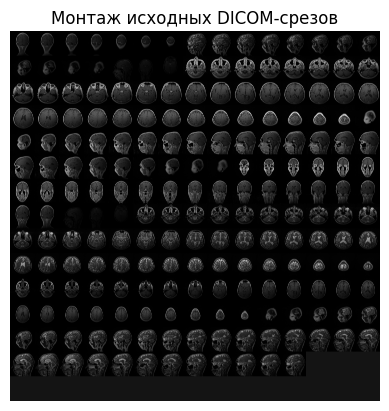

Диапазон значений в Ds: 0 4095
Выбранный iso-уровень: 2047.5


C:\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


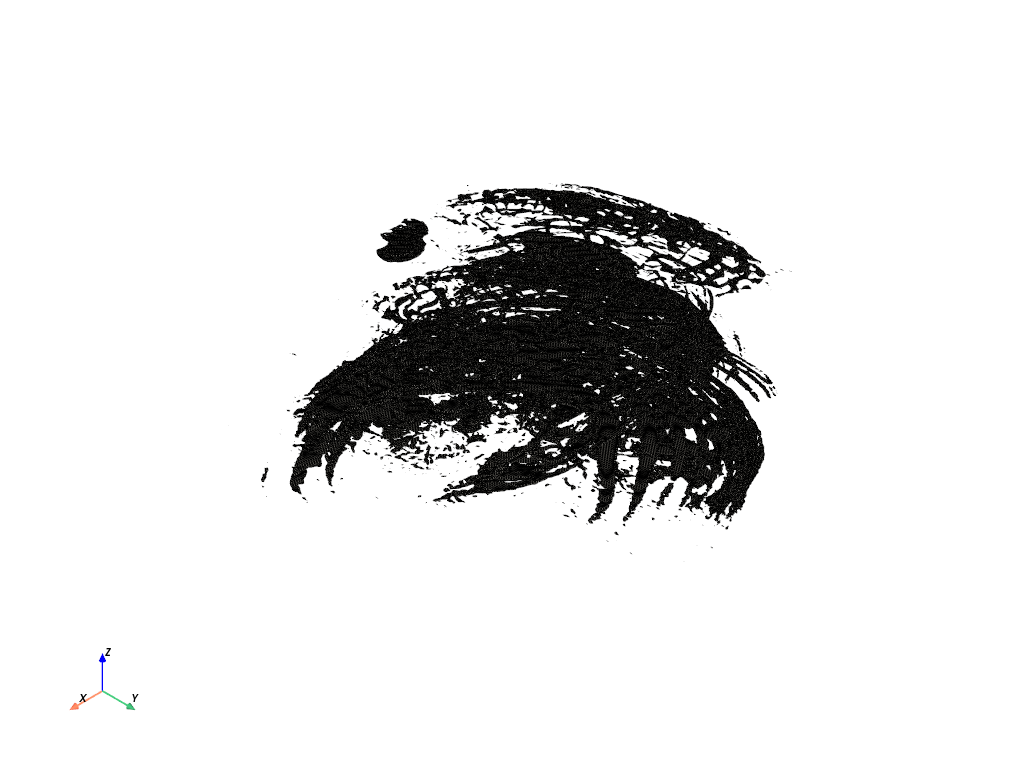

In [1]:
#!/usr/bin/env python3
"""
Интерактивная 3D-визуализация исходного объёма МРТ в натуральном оттенке с использованием PyVista.
Необходимо установить:
    pip install numpy matplotlib pydicom scikit-image pyvista
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import resize
from skimage.measure import marching_cubes
from skimage.util import montage as montage_util
import pyvista as pv

#############################################
# 1. Загрузка DICOM-файлов (без расширения)
#############################################
folder_path = os.path.join(os.getcwd(), r"E:\dicom dataset\1П\DICOM\13050311\59150000")

all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files = [os.path.join(folder_path, f) for f in all_files if os.path.splitext(f)[1] == '']

if not dicom_files:
    sys.exit("Файлы не найдены в указанной папке.")

print("Найдено DICOM файлов (без расширения):", len(dicom_files))

#############################################
# 2. Формирование списка 2D-изображений
#############################################
data_images_list = []
for file in sorted(dicom_files):
    try:
        ds = pydicom.dcmread(file)
        if 'PixelData' in ds:
            img = ds.pixel_array.astype(np.uint16)
            data_images_list.append(img)
        else:
            print(f"Пропускаем файл {file} (нет пиксельных данных)")
    except Exception as e:
        print(f"Ошибка при чтении файла {file}: {e}")

# Если форма некоторых изображений различается, приводим их к форме первого среза.
target_shape = data_images_list[0].shape
aligned_images = []
for idx, img in enumerate(data_images_list):
    if img.shape != target_shape:
        print(f"Изображение {dicom_files[idx]} имеет форму {img.shape}. Изменяем до {target_shape}.")
        new_img = resize(img, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint16)
        aligned_images.append(new_img)
    else:
        aligned_images.append(img)

data_images = np.stack(aligned_images, axis=2)
print("Сформирован 3D-массив с формой:", data_images.shape)

#############################################
# 3. (Необязательно) Вывести монтаж срезов для контроля
#############################################
montage_img = montage_util(data_images.transpose(2, 0, 1), grid_shape=None)
plt.figure()
plt.imshow(montage_img, cmap='gray')
plt.title("Монтаж исходных DICOM-срезов")
plt.axis('off')
plt.show()

#############################################
# 4. Downsample объёма для ускорения обработки (опционально)
#############################################
Ds = resize(data_images,
            (data_images.shape[0] // 2, data_images.shape[1] // 2, data_images.shape[2] // 2),
            order=0, preserve_range=True, anti_aliasing=False).astype(np.uint16)
# Здесь дополнительных переворотов можно не делать, если не требуется менять ориентацию.
# Если нужно, можно добавить np.flip или np.transpose.

#############################################
# 5. Извлечение изоповерхности
#############################################
# Выбираем iso-уровень автоматически (напр., с помощью среднего значения или метода Оцу).
ds_min, ds_max = Ds.min(), Ds.max()
print("Диапазон значений в Ds:", ds_min, ds_max)

# Например, можно взять уровень, равный среднему значению:
iso_level = ds_min + 0.5 * (ds_max - ds_min)
print("Выбранный iso-уровень:", iso_level)

try:
    verts, faces, normals, values = marching_cubes(Ds, level=iso_level)
except RuntimeError as e:
    sys.exit("Ошибка при извлечении изоповерхности: " + str(e))

# Для масштабирования учитываем, что при downsampling размер вокселя изменился (уменьшился в 2 раза).
# Если исходный voxel_size не нужен для корректного масштаба, можно применить коэффициент масштабирования.
# Здесь просто используем масштаб 1:1 для наглядности:
verts_scaled = verts  # Или, если хотите масштабировать, примените коэффициенты: verts * scale_vector

#############################################
# 6. Интерактивная 3D-визуализация через PyVista
#############################################
# Преобразуем faces в формат, подходящий для PyVista:
faces_pv = np.hstack([np.insert(face, 0, 3) for face in faces])

mesh = pv.PolyData(verts_scaled, faces_pv)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color="lightgrey", show_edges=True)
plotter.add_axes()  # Добавляем оси для ориентации
plotter.show()  # Открывает интерактивное окно


In [2]:
pip install vtk


Note: you may need to restart the kernel to use updated packages.
